In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, cuda


THRESHOLD = 200
N_ROTATION_SLICES = 72
MAX_SCALE = 1.4
MIN_SCALE = 0.6
DELTA_SCALE_RATIO = 0.1
N_SCALE_SLICE = int((MAX_SCALE - MIN_SCALE) // DELTA_SCALE_RATIO + 1)
BLOCK_SIZE = 10
THRESHOLD_RATIO = 0.3
DELTA_ROTATION_ANGLE = 360 / N_ROTATION_SLICES
IMAGE_DIR = '../../images'

# numpy array sobel filter
sobel_filter_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_filter_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])


@cuda.jit
def convert_to_gray(image: np.array, result: np.array):
    r, c = cuda.grid(2)
    if r < image.shape[0] and c < image.shape[1]:
        result[r][c] = 0.299 * image[r][c][0] + 0.587 * image[r][c][1] + 0.114 * image[r][c][2]


@cuda.jit
def convolve(sobel_filter: np.array, gray_src: np.array, result: np.array):
    r, c = cuda.grid(2)
    if r < gray_src.shape[0] and c < gray_src.shape[1]:
        temp = 0
        for jj in range(-1, 2):
            for ii in range(-1, 2):
                jj_pad = max(0, min(gray_src.shape[1] - 1, c + jj))
                ii_pad = max(0, min(gray_src.shape[0] - 1, r + ii))
                temp += gray_src[ii_pad][jj_pad] * sobel_filter[ii + 1][jj + 1]
        result[r][c] = temp


class ParallelGeneralHoughTransformGPU:
    def __init__(self, src: np.array, template: np.array, image_dir=IMAGE_DIR):
        self.src = src
        self.height_src = src.shape[0]
        self.width_src = src.shape[1]
        self.template = template
        self.height_template = template.shape[0]
        self.width_template = template.shape[1]
        self.r_table = [[] for _ in range(N_ROTATION_SLICES)]
        self.image_dir = image_dir
        self.block_size = (32, 32)
        self.grid_size_template = (math.ceil(self.height_template / self.block_size[0]), math.ceil(self.width_template / self.block_size[1]))
        self.grid_size_src = (math.ceil(self.height_src / self.block_size[0]), math.ceil(self.width_src / self.block_size[1]))

    def process_template(self):
        print("----------Start processing template----------\n")
        time_process = 0

        # Gray convert
        gray_template = np.zeros(self.template.shape[:2], dtype=np.float64)
        start = time.time()
        convert_to_gray[self.grid_size_template, self.block_size](self.template, gray_template)
        end = time.time()
        time_process += end - start

        # Sobel filter
        magnitude_x = np.zeros_like(gray_template)
        magnitude_y = np.zeros_like(gray_template)
        start = time.time()
        convolve[self.grid_size_template, self.block_size](sobel_filter_x, gray_template, magnitude_x)
        convolve[self.grid_size_template, self.block_size](sobel_filter_y, gray_template, magnitude_y)
        end = time.time()
        time_process += end - start

        # Magnitude and orientation
        start = time.time()
        magnitude = self.magnitude(magnitude_x, magnitude_y)
        orientation = self.orientation(magnitude_x, magnitude_y)
        end = time.time()
        time_process += end - start

        # Edge minmax
        start = time.time()
        edge_minmax = self.edgemns(magnitude, orientation)
        end = time.time()
        time_process += end - start

        # Threshold
        start = time.time()
        mag_threshold = self.threshold(edge_minmax, THRESHOLD, type_input='template')
        end = time.time()
        time_process += end - start

        # Create R-table
        start = time.time()
        self.create_r_table(orientation, mag_threshold)
        end = time.time()
        time_process += end - start

        print("----------End processing template----------\n")
        print(f"Time processing template: {time_process}\n")

    def accumulate_src(self):
        print("----------Start accumulating src----------\n")
        time_process = 0

        # Gray convert
        gray_src = np.zeros(self.template.shape[:2], dtype=np.float64)
        start = time.time()
        convert_to_gray[self.grid_size_src, self.block_size](self.src, gray_src)
        end = time.time()
        time_process += end - start

        # Sobel filter
        magnitude_x = np.zeros_like(gray_src)
        magnitude_y = np.zeros_like(gray_src)
        start = time.time()
        convolve[self.grid_size_src, self.block_size](sobel_filter_x, gray_src, magnitude_x)
        convolve[self.grid_size_src, self.block_size](sobel_filter_y, gray_src, magnitude_y)
        end = time.time()
        time_process += end - start

        # Magnitude and orientation
        start = time.time()
        magnitude = self.magnitude(magnitude_x, magnitude_y)
        orientation = self.orientation(magnitude_x, magnitude_y)
        end = time.time()
        time_process += end - start

        # Edge minmax
        start = time.time()
        edge_minmax = self.edgemns(magnitude, orientation)
        end = time.time()
        time_process += end - start

        # Threshold
        start = time.time()
        mag_threshold = self.threshold(edge_minmax, THRESHOLD)
        end = time.time()
        time_process += end - start

        # Accumulate
        start = time.time()
        block_maxima, maxima_threshold = self.accumulate(mag_threshold, orientation)
        end = time.time()
        time_process += end - start

        # Draw
        wblock = (self.width_src + BLOCK_SIZE - 1) // BLOCK_SIZE
        hblock = (self.height_src + BLOCK_SIZE - 1) // BLOCK_SIZE
        plt.imshow(self.src)
        for j in range(hblock):
            for i in range(wblock):
                if block_maxima[j][i]['hits'] > maxima_threshold:
                    plt.plot([block_maxima[j][i]['x']], [block_maxima[j][i]['y']], marker='o', color="yellow")

        plt.savefig(f'{self.image_dir}/output.png')
        plt.show()

        print("----------End accumulating src----------\n")
        print(f"Time process: {time_process}s\n")

    @jit(cache=True)
    def magnitude(self, magnitude_x: np.array, magnitude_y: np.array, type_input=None):
        result = np.zeros_like(magnitude_x)
        for i in range(magnitude_x.shape[0]):
            for j in range(magnitude_x.shape[1]):
                result[i][j] = math.sqrt(magnitude_x[i][j] ** 2 + magnitude_y[i][j] ** 2)

        return result

    @jit(cache=True)
    def orientation(self, magnitude_x: np.array, magnitude_y: np.array):
        result = np.zeros_like(magnitude_x)
        for i in range(magnitude_x.shape[0]):
            for j in range(magnitude_x.shape[1]):
                result[i][j] = (math.atan2(magnitude_y[i][j], magnitude_x[i][j]) * 180 / math.pi + 360) % 360
        return result

    @jit(cache=True)
    def edgemns(self, magnitude: np.array, orientation: np.array, type_input=None):
        result = np.zeros_like(magnitude)
        for i in range(magnitude.shape[0]):
            for j in range(magnitude.shape[1]):
                pixel_gradient = int(orientation[i][j] // 45) * 45 % 180
                neighbour_one_i = i
                neighbour_one_j = j
                neighbour_two_i = i
                neighbour_two_j = j

                if pixel_gradient == 0:
                    neighbour_one_i = i - 1
                    neighbour_two_i = i + 1
                elif pixel_gradient == 45:
                    neighbour_one_i = i + 1
                    neighbour_one_j = j - 1
                    neighbour_two_i = i - 1
                    neighbour_two_j = j + 1
                elif pixel_gradient == 90:
                    neighbour_one_j = j - 1
                    neighbour_two_j = j + 1
                elif pixel_gradient == 135:
                    neighbour_one_i = i - 1
                    neighbour_one_j = j - 1
                    neighbour_two_i = i + 1
                    neighbour_two_j = j + 1

                neighbour_one_i = max(0, min(magnitude.shape[0] - 1, neighbour_one_i))
                neighbour_one_j = max(0, min(magnitude.shape[1] - 1, neighbour_one_j))
                neighbour_two_i = max(0, min(magnitude.shape[0] - 1, neighbour_two_i))
                neighbour_two_j = max(0, min(magnitude.shape[1] - 1, neighbour_two_j))

                neighbour_one = magnitude[neighbour_one_i][neighbour_one_j]
                neighbour_two = magnitude[neighbour_two_i][neighbour_two_j]

                if (neighbour_one <= magnitude[i][j]) & (neighbour_two <= magnitude[i][j]):
                    result[i][j] = magnitude[i][j]
                else:
                    result[i][j] = 0
        return result

    @jit(cache=True)
    def threshold(self, magnitude: np.array, threshold: int, type_input=None):
        result = np.zeros_like(magnitude)
        for i in range(magnitude.shape[0]):
            for j in range(magnitude.shape[1]):
                if magnitude[i][j] > threshold:
                    result[i][j] = 255
                else:
                    result[i][j] = 0
        return result

    @jit(cache=True)
    def create_r_table(self, orientation: np.array, magnitude_threshold: np.array):
        for i in range(orientation.shape[0]):
            for j in range(orientation.shape[1]):
                if magnitude_threshold[i][j] == 255:
                    phi = orientation[i][j] % 360
                    i_slice = int(phi // DELTA_ROTATION_ANGLE)

                    center_x = self.width_template // 2
                    center_y = self.height_template // 2
                    entry_x = center_x - j
                    entry_y = center_y - i

                    r = math.sqrt(entry_x ** 2 + entry_y ** 2)
                    alpha = math.atan2(entry_y, entry_x)

                    entry = {'r': r, 'alpha': alpha}
                    self.r_table[i_slice].append(entry)

    @jit(cache=True)
    def accumulate4D(self, mag_threshold: np.array, orient: np.array):
        width = self.width_src
        height = self.height_src
        wblock = (width + BLOCK_SIZE - 1) // BLOCK_SIZE
        hblock = (height + BLOCK_SIZE - 1) // BLOCK_SIZE

        accumulator = np.zeros((N_SCALE_SLICE, N_ROTATION_SLICES, hblock, wblock), dtype=np.int32)
        block_maxima = np.zeros((hblock, wblock), dtype=[('x', int), ('y', int), ('hits', int)])

        _max = 0
        for j in range(height):
            for i in range(width):
                if mag_threshold[j][i] == 255:
                    phi = orient[j][i]
                    for i_theta in range(N_ROTATION_SLICES):
                        theta = i_theta * DELTA_ROTATION_ANGLE
                        theta_r = math.radians(theta)
                        i_slice = int(((phi - theta + 360) % 360) // DELTA_ROTATION_ANGLE)
                        entries = self.r_table[i_slice]
                        for entry in entries:
                            r = entry['r']
                            alpha = entry['alpha']
                            for scale in range(N_SCALE_SLICE):
                                s = scale * DELTA_SCALE_RATIO + MIN_SCALE
                                xc = int(i + r * s * math.cos(alpha + theta_r))
                                yc = int(j + r * s * math.sin(alpha + theta_r))

                                if xc < 0 or xc >= width or yc < 0 or yc >= height:
                                    continue
                                accumulator[scale][i_theta][yc // BLOCK_SIZE][xc // BLOCK_SIZE] += 1
                                if accumulator[scale][i_theta][yc // BLOCK_SIZE][xc // BLOCK_SIZE] > \
                                        block_maxima[yc // BLOCK_SIZE][xc // BLOCK_SIZE]['hits']:
                                    block_maxima[yc // BLOCK_SIZE][xc // BLOCK_SIZE]['hits'] = \
                                        accumulator[scale][i_theta][yc // BLOCK_SIZE][xc // BLOCK_SIZE]
                                    block_maxima[yc // BLOCK_SIZE][xc // BLOCK_SIZE]['x'] = xc
                                    block_maxima[yc // BLOCK_SIZE][xc // BLOCK_SIZE]['y'] = yc
                                    if accumulator[scale][i_theta][yc // BLOCK_SIZE][xc // BLOCK_SIZE] > _max:
                                        _max = accumulator[scale][i_theta][yc // BLOCK_SIZE][xc // BLOCK_SIZE]

        maxima_threshold = round(_max * THRESHOLD_RATIO)

        return block_maxima, maxima_threshold

    @jit(cache=True)
    def accumulate(self, mag_threshold: np.array, orient: np.array):
        width = self.width_src
        height = self.height_src
        wblock = (width + BLOCK_SIZE - 1) // BLOCK_SIZE
        hblock = (height + BLOCK_SIZE - 1) // BLOCK_SIZE

        accumulator = np.zeros((hblock, wblock), dtype=np.int32)
        block_maxima = np.zeros((hblock, wblock), dtype=[('x', int), ('y', int), ('hits', int)])

        _max = 0
        for j in range(self.height_src):
            for i in range(self.width_src):
                if mag_threshold[j][i] == 255:
                    phi = orient[j][i]
                    i_slice = int(phi // DELTA_ROTATION_ANGLE)
                    entries = self.r_table[i_slice]
                    for entry in entries:
                        r = entry['r']
                        alpha = entry['alpha']
                        xc = int(i + r * math.cos(alpha))
                        yc = int(j + r * math.sin(alpha))

                        if xc < 0 or xc >= self.width_src or yc < 0 or yc >= self.height_src:
                            continue
                        accumulator[yc // BLOCK_SIZE][xc // BLOCK_SIZE] += 1
                        block_maxima[yc // BLOCK_SIZE][xc // BLOCK_SIZE]['hits'] = accumulator[yc // BLOCK_SIZE][
                            xc // BLOCK_SIZE]
                        block_maxima[yc // BLOCK_SIZE][xc // BLOCK_SIZE]['x'] = xc
                        block_maxima[yc // BLOCK_SIZE][xc // BLOCK_SIZE]['y'] = yc
                        if accumulator[yc // BLOCK_SIZE][xc // BLOCK_SIZE] > _max:
                            _max = accumulator[yc // BLOCK_SIZE][xc // BLOCK_SIZE]
        maxima_threshold = round(_max * THRESHOLD_RATIO)
        return block_maxima, maxima_threshold


In [3]:
@cuda.jit
def convertToGray(image: np.array, result: np.array):
    r, c = cuda.grid(2)
    if r < image.shape[0] and c < image.shape[1]:
        result[r][c] = 0.299 * image[r][c][0] + 0.587 * image[r][c][1] + 0.114 * image[r][c][2]

In [5]:
import cv2
block_size = (32, 32)
src = cv2.imread("drive/MyDrive/ltss_seminar/images/leaves.png")
height_src = src.shape[0]
width_src = src.shape[1]
template = cv2.imread("drive/MyDrive/ltss_seminar/images/leaf.png")
height_template = template.shape[0]
width_template = template.shape[1]
grid_size_template = (math.ceil(height_template / block_size[0]), math.ceil(width_template / block_size[1]))
grid_size_src = (math.ceil(height_src / block_size[0]), math.ceil(width_src / block_size[1]))

In [7]:
gray_template = np.zeros(template.shape[:2], dtype=np.float64)
start = time.time()
convertToGray[grid_size_template, block_size](template, gray_template)
end = time.time()
time_process = end - start
time_process

/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


0.009307861328125

In [11]:
gray_src = np.zeros(src.shape[:2], dtype=np.float64)
start = time.time()
convertToGray[grid_size_src, block_size](src, gray_src)
end = time.time()
time_process += end - start
time_process

/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


0.0770878791809082

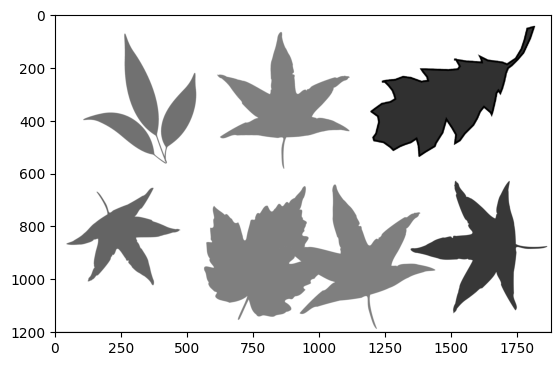

In [12]:
plt.imshow(gray_src, cmap='gray')

----------Start processing template----------



/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
<ipython-input-2-6e9fbcd1f35b>:149: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "convolve" failed type inference due to: non-precise type pyobject
During: typing of argument at <ipython-input-2-6e9fbcd1f35b> (151)

File "<ipython-input-2-6e9fbcd1f35b>", line 151:
    def convolve(self, sobel_filter: np.array, gray_src: np.array, axis='x', type_input=None):
        result = np.zeros_like(gray_src)
        ^

  @jit(cache=True)
<ipython-input-2-6e9fbcd1f35b>:149: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "convolve" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-2-6e9fbcd1f35b>", line 15

----------End processing template----------

Time processing template: 5.918285131454468

----------Start accumulating src----------



/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
<ipython-input-2-6e9fbcd1f35b>:223: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "threshold" failed type inference due to: non-precise type pyobject
During: typing of argument at <ipython-input-2-6e9fbcd1f35b> (225)

File "<ipython-input-2-6e9fbcd1f35b>", line 225:
    def threshold(self, magnitude: np.array, threshold: int, type_input=None):
        result = np.zeros_like(magnitude)
        ^

  @jit(cache=True)
<ipython-input-2-6e9fbcd1f35b>:223: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "threshold" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-2-6e9fbcd1f35b>", line 226:
    def th

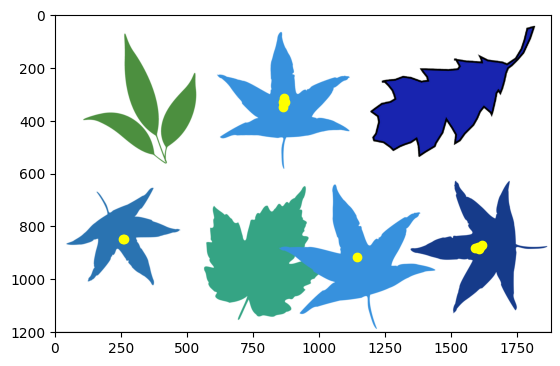

In [13]:
import cv2
IMAGE_DIR = 'drive/MyDrive/ltss_seminar/images'
template = cv2.imread("drive/MyDrive/ltss_seminar/images/leaf.png")
src = cv2.imread("drive/MyDrive/ltss_seminar/images/leaves.png")
ght = ParallelGeneralHoughTransformGPU(src, template, image_dir=IMAGE_DIR)
ght.process_template()
ght.accumulate_src()  